In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import re
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import keras
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import requests
from xml.etree import ElementTree as ET
from datetime import datetime

In [59]:
userId = 1
lat = 60
lon = 127
date = 1713193200

In [60]:
# epoch time을 datetime 형식으로 변환
def epoch_to_datetime(epoch_time):
    return datetime.fromtimestamp(epoch_time)

In [61]:
# datetime을 epoch time으로 변환
def datetime_to_epoch(datetime_time):
    return int(datetime_time.timestamp())

In [62]:
datetime = epoch_to_datetime(date)
# datetime에서 년월일 형식으로 변환
today = datetime.strftime('%Y%m%d')

In [63]:
# Today's date
today = datetime.today().strftime("%Y%m%d")

In [72]:
# API endpoint
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

# API key
service_key = "2tvkzWa/Da5wAH2C4F09CShggc7fixR0Jowlz4jhXWSCwlVk+AbL2Yxt7QmsCKRf0ijOA0IxzzNPHTQeLhxixQ=="

# Parameters
params = {
    "serviceKey": service_key,
    "numOfRows": 100,  # Increase the number of rows to get more temperature data
    "pageNo": 1,
    "dataType": "XML",
    "base_date": today,
    "base_time": "0200",
    "nx": lat,
    "ny": lon 
}

# Send request
response = requests.get(url, params=params)
'''print(response.content)'''

# Parse XML response
root = ET.fromstring(response.content)

# Find temperature data
temps = [float(item.find('fcstValue').text) for item in root.iter('item') if item.find('category').text == 'TMP']
rain = [float(item.find('fcstValue').text) for item in root.iter('item') if item.find('category').text == 'PTY']
wind = [float(item.find('fcstValue').text) for item in root.iter('item') if item.find('category').text == 'WSD']
humidity = [float(item.find('fcstValue').text) for item in root.iter('item') if item.find('category').text == 'REH']

# Calculate average temperature
avg_temp = sum(temps) / len(temps)
min_temp = min(temps)
max_temp = max(temps)
rain = any(r > 0 for r in rain)
avg_wind = sum(wind) / len(wind)
avg_humidity = sum(humidity) / len(humidity)

'''print(f"Today's average temperature: {avg_temp}")
print(f"Today's minimum temperature: {min_temp}")
print(f"Today's maximum temperature: {max_temp}")
print(f"Is it raining today? {'Yes' if rain else 'No'}")
print(f"Today's average wind speed: {avg_wind}")
print(f"Today's average humidity: {avg_humidity}")'''

'print(f"Today\'s average temperature: {avg_temp}")\nprint(f"Today\'s minimum temperature: {min_temp}")\nprint(f"Today\'s maximum temperature: {max_temp}")\nprint(f"Is it raining today? {\'Yes\' if rain else \'No\'}")\nprint(f"Today\'s average wind speed: {avg_wind}")\nprint(f"Today\'s average humidity: {avg_humidity}")'

In [65]:
# csv 파일을 dataframe으로 변환
df_outfit = pd.read_csv('../data/outfit(male)/outfit(male).csv')
df_weather = pd.read_csv('../data/2022-08-01_to_2024-04-30.csv', encoding='cp949')
# 필요한 columns만 추출
df_outfit = df_outfit[['userId', '상의', '아우터', '하의', '신발', '액세서리', '작성일']].copy()
df_temp = df_weather[['일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '강수 계속시간(hr)', '평균 풍속(m/s)', '평균 상대습도(%)']].copy()

# '작성일'과 '일시' 열을 datetime 형식으로 변환
df_outfit['작성일'] = pd.to_datetime(df_outfit['작성일'], format='%Y년 %m월 %d일')
df_temp['일시'] = pd.to_datetime(df_temp['일시'])

# 두 dataframe을 날짜를 기준으로 병합
df_merged = pd.merge(df_outfit, df_temp, left_on='작성일', right_on='일시').drop('일시', axis=1)

In [66]:
# 평균기온(°C), 최저기온(°C), 최고기온(°C), 강수 계속시간(hr), 평균 풍속(m/s), 평균 상대습도(%) 열의 결측치를 0으로 대체
df_notnull = df_merged.copy()
w_columns = ['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '강수 계속시간(hr)', '평균 풍속(m/s)', '평균 상대습도(%)']
df_notnull[w_columns] = df_notnull[w_columns].fillna(0)
df_notnull['강수 계속시간(hr)'] = df_notnull['강수 계속시간(hr)'].apply(lambda x: 1 if x > 0 else 0)

In [67]:
df_fill = df_notnull.copy()
# '상의', '아우터', '하의', '신발', '엑세서리' 열의 결측값을 '~ 없음'으로 대체
o_columns = ['상의', '아우터', '하의', '신발', '액세서리']
for column in o_columns:
    df_fill[column] = df_notnull[column].fillna(column + ' 없음')

In [68]:
# 평균기온(°C), 최저기온(°C), 최고기온(°C), 강수 계속시간(hr), 평균 풍속(m/s), 평균 상대습도(%) 열을 표준화
scaler = StandardScaler()
df_scaled = df_fill.copy()
df_scaled[w_columns] = scaler.fit_transform(df_notnull[w_columns])

In [69]:
# 현재 날씨를 입력 하고 변환을 적용			
df_today = pd.DataFrame(columns=['평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '강수 계속시간(hr)', '평균 풍속(m/s)', '평균 상대습도(%)'])
# 13.3	12.2	15	16.17	3	77.3로 초기화
df_today.loc[0] = [avg_temp, min_temp, max_temp, rain, avg_wind, avg_humidity]
df_today[w_columns] = df_today[w_columns].fillna(0)
df_today['강수 계속시간(hr)'] = df_today['강수 계속시간(hr)'].apply(lambda x: 1 if x > 0 else 0)
# 표준화 적용
df_today[w_columns] = scaler.transform(df_today)

In [78]:
# 전체 데이터에서 날씨 유사도를 계산
all_similarity = cosine_similarity(df_scaled[w_columns], df_today[w_columns])

array([[-0.88680702],
       [ 0.66787659],
       [-0.638717  ],
       ...,
       [ 0.69243164],
       [ 0.86427886],
       [ 0.82157327]])

In [91]:
# 각 userid마다 현재 날씨와 기록된 날씨의 cosine similarity를 계산하고 각 userid마다 가장 높은 similarity를 가지는 3개의 row를 추출
user_ids = df_fill['userId'].unique()
similarities = []
indices = []
df_user = df_scaled[df_scaled['userId'] == userId]
df_user = df_user[w_columns]
df_user = pd.concat([df_today, df_user])
similarity = cosine_similarity(df_user)
similarities.append(similarity[0][1:])
# 3개의 row index를 추출
index = np.argsort(similarity[0][1:])[-3:]
# all_similarity를 기준으로 75% quantiles값 이상이 되지 않는다면 해당 값을 index에서 제거
if np.quantile(all_similarity, 0.9) > similarity[0][1:][index[0]]:
    index = index[1:]
    if np.quantile(all_similarity, 0.9) > similarity[0][1:][index[0]]:
        index = index[1:]
        if np.quantile(all_similarity, 0.9) > similarity[0][1:][index[0]]:
            index = []
# index의 similarity 값 확인
for i in index:
    print(similarity[0][1:][i])
indices.append(index)

0.8638426714774705
0.8638426714774705
0.9694048570414621


In [90]:
np.quantile(all_similarity, 0.999)

0.9815558308093073

0.7064449016066456

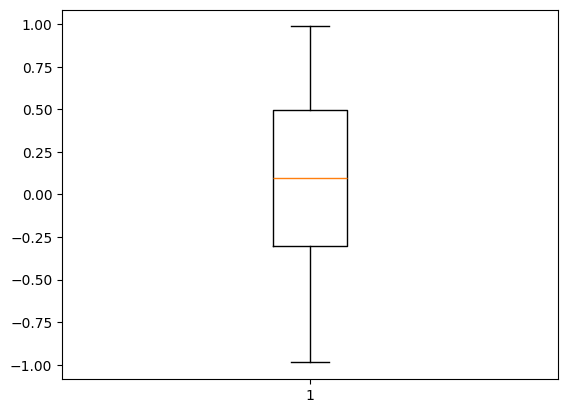

In [82]:
#similarity를 boxplot으로 보여줌
plt.boxplot(all_similarity)
np.quantile(all_similarity, 0.90)

In [71]:
# user마다 가장 높은 similarity를 가지는 3개의 row를 df_fill에서 추출
df_recommend = pd.DataFrame(columns=df_fill.columns)
df_user = df_fill[df_fill['userId'] == userId]
df_user = df_user.iloc[index]
df_recommend = pd.concat([df_recommend, df_user])
# 작성일 column의 값을 epoch time의 배열로 저장
recommend_dates = []
for date in df_recommend['작성일']:
    recommend_dates.append(datetime_to_epoch(date))
print(recommend_dates)

[1698624000, 1698624000, 1681430400]


/tmp/ipykernel_108709/3123101736.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_recommend = pd.concat([df_recommend, df_user])
